# WATER BAG CLASSIFICATION - CLUSTER MODELS
### BASED ON INMET AND ALERTA-RIO METHEOROLOGICAL STATIONS DATA

---
## Define Functions

In [2]:
def a():
    b = 10

In [4]:
a()

In [5]:
b

NameError: name 'b' is not defined

#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [136]:
import os, json, pandas as pd, numpy as np, pickle
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Time serie features transformation pipeline & binary classification pipeline (Authoral)
from Modulos.sample_filter import min_max_filter_stats, min_max_filter, filter_by_stats
from Modulos.timeserie_transform import TimeseriesTransformPipeline
from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample
from Modulos.imbalanced_classification import ClassificationPipeline, classesGroupRecall

#### Preprocessing & machine learning modules
from sklearn.preprocessing import MinMaxScaler as mms
from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt
from sklearn.utils import all_estimators
from sklearn.metrics import classification_report as cr
from imblearn import ensemble

#  Classifier colleciton
classifiers = dict(all_estimators('classifier'))

# Select specific classification models
gbc = classifiers['GradientBoostingClassifier']
brfc = ensemble.BalancedRandomForestClassifier

#### Define metrics and scoring functions
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, precision_recall_fscore_support

recall_0 = make_scorer(recall_score, pos_label=0)
recall_1 = make_scorer(recall_score, pos_label=1)
precision_0 = make_scorer(precision_score, pos_label=0)
precision_1 = make_scorer(precision_score, pos_label=1)
f1_1 = make_scorer(f1_score, pos_label=1)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall', 'precision': 'precision',
    'recall-0': recall_0, 'recall-1': recall_1,
    'precision-0': precision_0, 'precision-1': precision_1,
    'f1-1': f1_1
}

### Custom functions

In [9]:
from sklearn.metrics import precision_recall_curve

def threshold_precision_recall_plot(ye, yprob, threshold):
    curve = pd.DataFrame(
        precision_recall_curve(ye, yprob, pos_label=1),
        index=['precision', 'recall', 'threshold']
    ).T.set_index('threshold').add_suffix(f' - 1')
    curve['f1 - 1'] = curve.mean(1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
    curve.plot(ax=ax)
    if threshold is not None:
        yhat_fix = (yprob > threshold).astype('int')
        scr = pd.DataFrame(cr(ye, yhat_fix, digits=4, output_dict=True)).T
        return ax, scr
    return ax

---
## Load & Preprocess Data

In [ ]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True)

data = project.data
group_ts = project.time_serie
waterbags = project.waterbags

# Drop records before july, 2018 to reduce imbalance
data = data[:]
group_ts = group_ts[:]

# Sample groups names per group label
routes = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

---
# Interactive multiple target modeling function

In [ ]:
from sklearn.linear_model import LinearRegression

transform_args = dict(
    scale=True, interpolate=None, fillna='mean'
)

def multi_target_pipeline(
    data, Yi, names,
    train_start, train_end,
    eval_start, eval_end,
    model=LinearRegression(),
    periods_ahead=4,
    transform_args=transform_args,
    close_feature_space=False,
    deploy_info_path=None,
    models_path=None,
    thresholds_path=None,
):
    # Select feature set
    X = TimeseriesTransformPipeline(
        data, train_start, cut=-1,
        drop_empty_cols=True,
        **transform_args,
    ); X = X[: eval_end]

    # Select raw feature set for preprocessing
    X_raw = TimeseriesTransformPipeline( # Must use untransformed data to perform filtering fiter
        data, train_start, cut=-1,
        drop_empty_cols=True, scale=False,
        interpolate=None, fillna=None
    ); X_raw = X_raw[: eval_end]

    # Validation split
    xt = X[:train_end]
    xe = X[eval_start: eval_end]

    if deploy_info_path is not None:
        # Save Features description
        X_info = X_raw.describe().loc[['min', 'max', 'mean']].T
        X_info.to_csv(deploy_info_path, index=True)
    
    target_results = []
    for i, target_id in enumerate(Yi):

        co(wait=True); print(f'Modeling target {names[int(target_id)]} - {i+1}/{Yi.shape[1]}')

        Y = Yi[str(target_id)].loc[X.index].copy()
        groups = groupConsecutiveFlags(ts=Y)
        display(Y.value_counts().to_frame('Target'))

        ### Target transformation
        if periods_ahead is not None:
            Y = (Y.rolling(periods_ahead, closed='left', min_periods=1).sum().shift(-periods_ahead + 1) > 0).astype('float')
            groups = groupConsecutiveFlags(ts=Y)
            display(Y.value_counts().to_frame('Transformed Target'))

        # Target validation split
        yt = Y.loc[xt.index]
        ye = Y.loc[xe.index]
        groups_train = groups.loc[xt.index]
        groups_eval = groups.loc[xe.index]

        ### Validation statistics ---

        cnts = [yt.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
        print('\nTrain folder'); display(pd.concat(cnts, 1))
        cnts = [ye.value_counts(norm).to_frame('Class Count') for norm in (False, True)]
        print('\nValidation folder'); display(pd.concat(cnts, 1))

        eval_size = len(ye) / len(Y) * 100
        eval_minority = (ye==1).sum() / (Y==1).sum() * 100
        train_minority = (ye==0).sum() / (Y==0).sum() * 100
        eval_stats = pd.DataFrame(
            [eval_size, train_minority, eval_minority],
            ['Samples left', 'Negative Samples left', 'Positive Samples left'],
            ['Validation (%)'],
        ).round(2)
        display(eval_stats)

        # --- Fit and evaluate model ---

        # Filter hour records by variables threshold (Optional)
        if close_feature_space:
            ### Records left after filtering by columns' minimum thresholds
            x_filt, y_filt, groups_filt = filter_by_stats(
                X_raw.loc[xt.index], yt, groups=groups_train,
                n_filters=[None, None], choose_from=50,
                acumulate='and', top_down=True,
                figsize=(11, 3)
            ); x_filt = xt.loc[x_filt.index].copy()
            model.fit(x_filt, y_filt)  # Evaluate validation folder
        else:
            model.fit(xt, yt)

        try: yprob = pd.Series(model.predict_proba(xe)[:, 1], index=xe.index)
        except: yprob = pd.Series(model.predict(xe), index=xe.index)
        ax = threshold_precision_recall_plot(ye, yprob, threshold=None)
        plt.show()
        
        threshold = float(input('Select decision threshold:'))
        yhat = (yprob >= threshold).astype('int')
        scr = pd.DataFrame(precision_recall_fscore_support(ye, yhat), index=['precision', 'recall', 'f1', 'support']).T
        display(scr)
        scr = pd.concat([scr.loc[label].add_suffix('-' + str(label)) for label in [0, 1]], 0)

        # --- Fit and save final model

        if close_feature_space:
            ### Refilter complete training data for final model
            X_filt, Y_filt, Groups_filt = filter_by_stats(
                X_raw, Y, groups=groups,
                n_filters=[None, None], choose_from=50,
                acumulate='and', top_down=True,
                figsize=(11, 3)
            ); X_filt = X.loc[X_filt.index].copy()
            final_model = model.fit(X_filt, Y_filt)
        else:
            final_model = model.fit(X, Y)

        model_info = {
            'id': target_id,
            'name': names[int(target_id)],
            'model': final_model,
            'threshold': threshold,
            'score': scr,
        }
        target_results.append(model_info)

        model_path = None
        if models_path is not None:
            model_path = models_path + model_info['name'] + '/'
            model_file = model_path + 'model_' + model_info['name'] + '-' + model_info['id'] + '.pickle'
            score_file = model_path + 'score_' + model_info['name'] + '-' + model_info['id'] + '.csv'
            if not os.path.exists(model_path):
                os.makedirs(model_path)
            pickle.dump(final_model, open(model_file, 'wb'))
            model_info['score'].to_csv(score_file, index=True)

        if thresholds_path is not None:
            thresh_i = json.loads(open(thresholds_path, 'r').read())
            thresh_i[model_info['id']] = threshold
            with open(thresholds_path, 'w') as file:
                file.write(json.dumps(thresh_i))

        print('\n\n\n')
        if input('Exit?')=='y': break
    return target_results

---

# Model multiple targets interactively

Modeling target Rua do Catete - 1/78


,Target
0.0,136496
1.0,783


,Transformed Target
0.0,136282
1.0,997



Train folder


,Class Count,Class Count
0.0,119037,0.992777
1.0,866,0.007223



Validation folder


,Class Count,Class Count
0.0,17245,0.992461
1.0,131,0.007539


,Validation (%)
Samples left,12.66
Negative Samples left,12.65
Positive Samples left,13.14


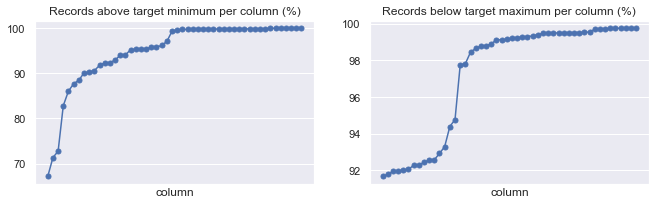

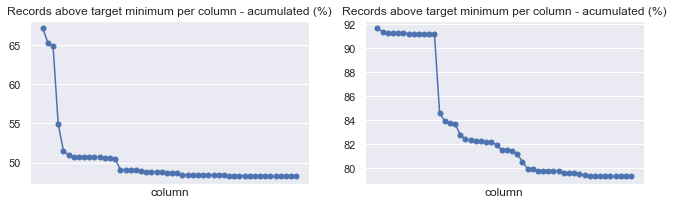

N° of columns to filter by minimum: 5
N° of columns to filter by maximum: 13



Positive minimum filter:

Records: 119903
Records left: 61796
Records left (%): 51.54 %

Positive maximum filter:

Records: 61796
Records left: 54492
Records left (%): 88.18 %



,Class Count,Percent left (%)
0.0,53626,45.05
1.0,866,100.00


      Iter       Train Loss   Remaining Time 
         1           0.0852            3.11m
         2           0.0797            2.45m
         3           0.0756            2.29m
         4           0.0720            2.32m
         5           0.0688            2.20m
         6           0.0660            2.17m
         7           0.0634            2.07m
         8           0.0616            1.99m
         9           0.0598            1.93m
        10           0.0578            1.87m
        20           0.0441            1.55m
        30           0.0380            1.30m
        40           0.0346            1.12m
        50           0.0320           55.54s
        60           0.0299           44.25s
        70           0.0284           33.34s
        80           0.0267           22.31s
        90           0.0253           11.22s
       100           0.0239            0.00s


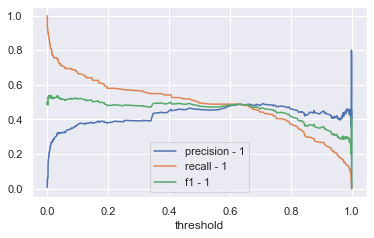

Select decision threshold: .1


,precision,recall,f1,support
0,0.997433,0.991476,0.994446,17245.0
1,0.371795,0.664122,0.476712,131.0


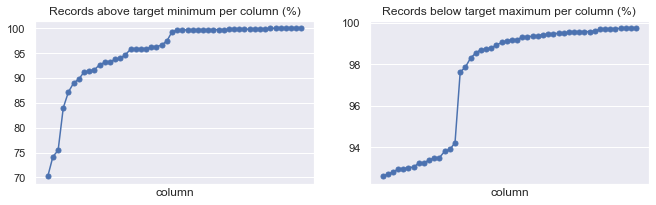

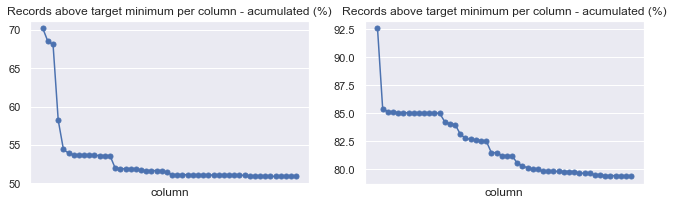

N° of columns to filter by minimum: 5
N° of columns to filter by maximum: 13



Positive minimum filter:

Records: 137279
Records left: 74720
Records left (%): 54.43 %

Positive maximum filter:

Records: 74720
Records left: 65564
Records left (%): 87.75 %



,Class Count,Percent left (%)
0.0,64567,47.38
1.0,997,100.00


      Iter       Train Loss   Remaining Time 
         1           0.0841            2.10m
         2           0.0805            2.14m
         3           0.0756            2.07m
         4           0.0724            2.04m
         5           0.0688            2.01m
         6           0.0662            1.98m
         7           0.0638            1.96m
         8           0.0612            1.93m
         9           0.0595            1.91m
        10           0.0578            1.88m
        20           0.0477            1.70m
        30           0.0429            1.55m
        40           0.0395            1.33m
        50           0.0373            1.11m
        60           0.0345           52.83s
        70           0.0329           39.31s
        80           0.0315           26.14s
        90           0.0302           13.01s
       100           0.0283            0.00s






In [ ]:
transform_args = dict(
    scale=True, interpolate='nearest', fillna='mean'
)

names = routes
train_start, train_end = '2018-06', '2021-10'
eval_start, eval_end = '2021-11', '2022-04'
model = gbc(random_state=0, verbose=1)
# model = LinearRegression()
periods_ahead = 4
close_feature_space = True

# eval_path = 'Modelagem de Bolsões/Results/probabilidade_catete.png'
deploy_info_path = 'API Deploy/deploy_info.csv'
models_path = 'API Deploy/Modelos/'
thresholds_path = 'API Deploy/thresholds.json'

target_results = multi_target_pipeline(
    data, group_ts.iloc[:, 2:], names,
    train_start, train_end,
    eval_start, eval_end,
    model, periods_ahead,
    transform_args,
    close_feature_space,
    deploy_info_path,
    models_path,
    thresholds_path
)